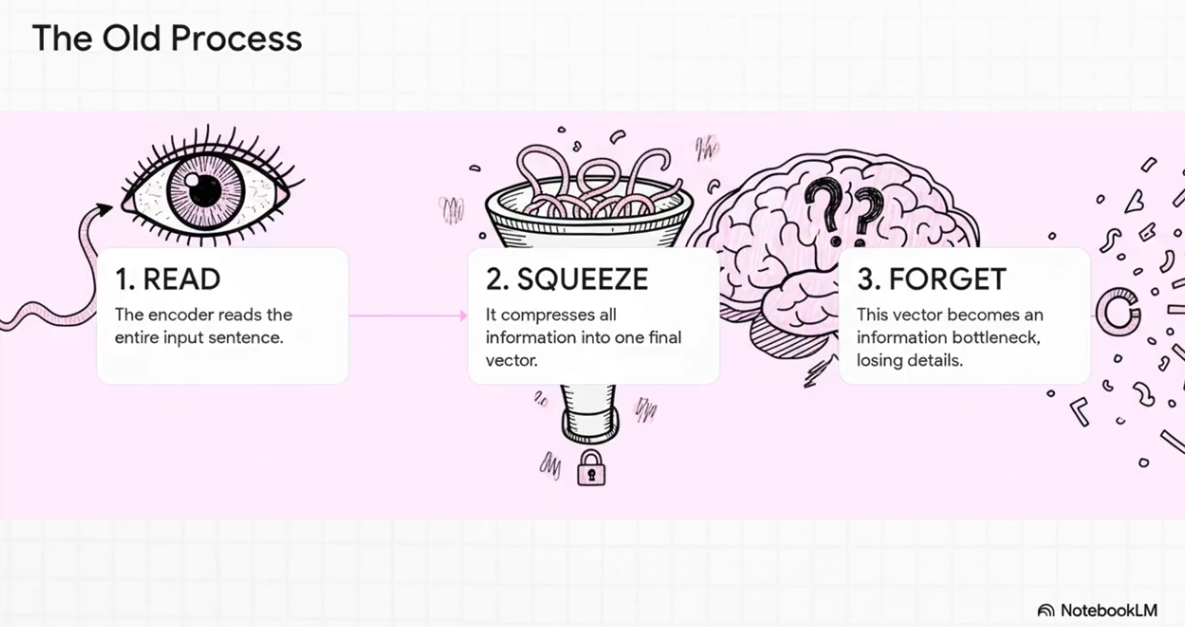

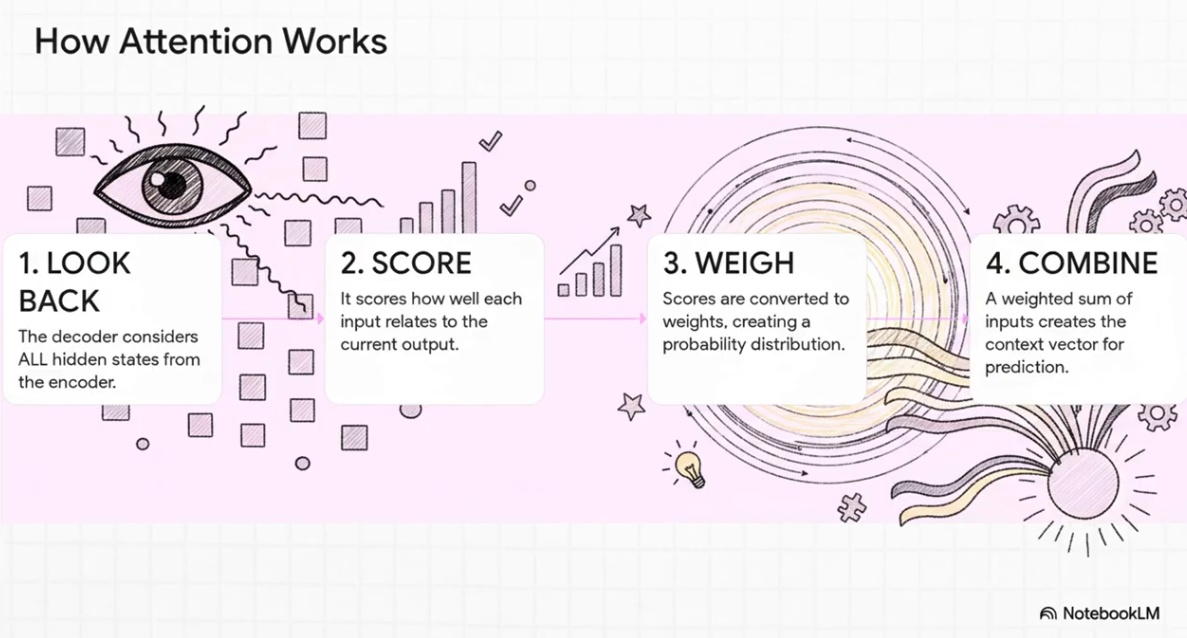

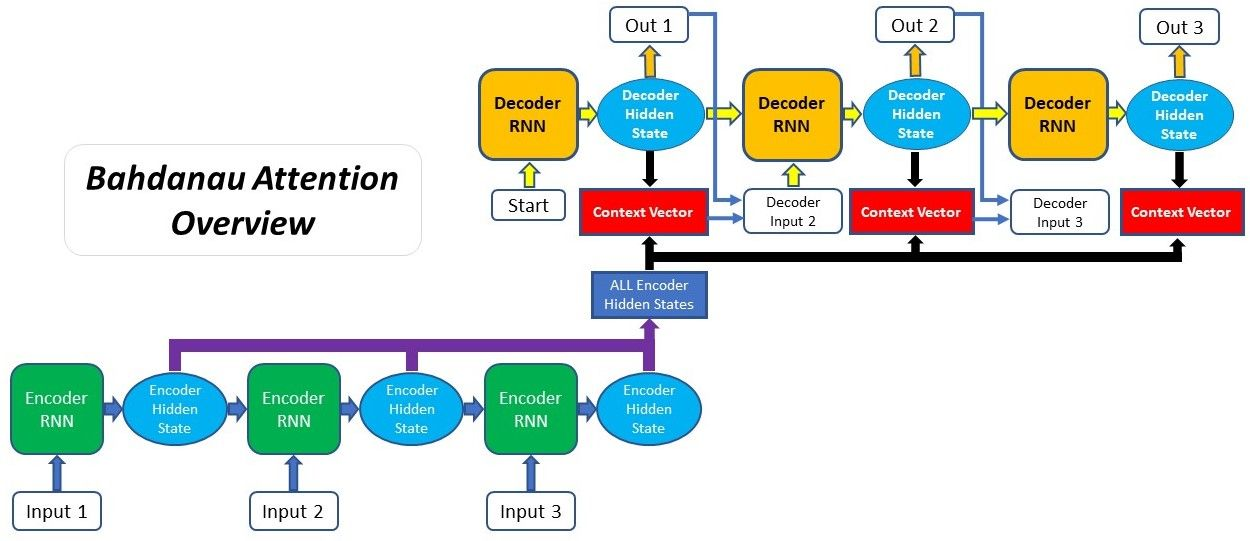

# 👉 Attention — allowing a model to dynamically focus on relevant parts of an input sequence when generating output.

# 🧠 Motivation Behind Bahdanau Attention
Early NMT models simplified translation pipelines but struggled with long sentences due to the fixed-length bottleneck.

A single context vector couldn’t capture all relevant information, so the model lost track of earlier words when translating the later ones.

💡 The Solution: Let the model softly attend to different parts of the input sentence while generating each target word.

By learning alignment scores between encoder and decoder states, the model could dynamically focus on the most relevant source words.

This eliminated the fixed-vector constraint, improved translation accuracy, and laid the foundation for today’s attention-based architectures — from Transformers to LLMs

🗣️ When Machines Struggled with Long Sentences
Before 2014, most machine translations systems were built using Recurrent Neural Networks (RNNs) or LSTMs that encoded the entire source sentence into a single fixed size vector — a bottleneck for long inputs.



In [ ]:
# https://medium.com/@nids.workspace.09/understanding-bahdanau-attention-56daad2300e5

# 🔍 How Bahdanau Attention Works (Additive Attention)

After understanding why early seq2seq models struggled with long sentences, we now introduce the mechanism that solved the fixed-length bottleneck.

Bahdanau Attention (also known as *Additive Attention*) allows the decoder to dynamically "focus" on relevant parts of the input sequence while generating each output token.

---

## 🧠 Key Idea

Instead of depending on one fixed context vector, the decoder computes **a new context vector at every decoding step**, focusing on the relevant encoder states.

This enables the model to:
- attend to important words
- ignore irrelevant ones
- handle long sentences effectively

---

## ⚙️ Step-by-Step Breakdown

### **1. Encoder Hidden States**

The encoder processes the input sequence and produces a set of hidden states:

$$
h_1, h_2, \ldots, h_T
$$

Each \( h_i \) represents information about the input token at position *i*.

---

### **2. Decoder Hidden State**

At decoding step \( t \), the decoder has its own hidden state:

$$
s_t
$$

This summarizes what the decoder knows up to step \( t \).

---

### **3. Alignment Scores**

Bahdanau introduced an alignment mechanism that scores how well each encoder hidden state matches the current decoder hidden state:

$$
e_{t,i} = v^{T}\,\tanh(W_1 h_i + W_2 s_t)
$$

This score measures how relevant encoder state \( h_i \) is for producing the next target token.

---

### **4. Softmax → Attention Weights**

The alignment scores are normalized using softmax to obtain attention weights:

$$
\alpha_{t,i} = \frac{\exp(e_{t,i})}{\sum_{j}\exp(e_{t,j})}
$$

Each \( \alpha_{t,i} \) is a probability that indicates how much the model should attend to input word *i* at step *t*.

---

### **5. Context Vector**

The context vector is computed as a weighted sum of all encoder hidden states:

$$
c_t = \sum_{i} \alpha_{t,i} \, h_i
$$

This context vector represents the specific information the decoder needs at time step *t*.

---

### **6. Decoder Output**

Finally, the decoder uses:
- the context vector \( c_t \)
- its own hidden state \( s_t \)
- the previously generated token

to compute the next output word.

---

# 🎯 Why Bahdanau Attention Works

- Removes the fixed-size bottleneck of earlier seq2seq models  
- Allows dynamic focus on different parts of the input  
- Learns alignment patterns automatically  
- Improves translation quality and fluency  
- Forms the foundation of modern attention-based architectures, including Transformers  


#

In [ ]:
#!pip install torch torchtext spacy
#!python -m spacy download en_core_web_sm

## 1. Import libraries & load IMDB dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

100%|██████████| 25.7M/25.7M [00:02<00:00, 12.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [ ]:
import pandas as pd
import os

csv_path = os.path.join(path, "IMDB Dataset.csv")
df = pd.read_csv(csv_path)

texts = df["review"].tolist()
labels = df["sentiment"].tolist()

print("Examples:", texts[0][:200])
texts=texts[:100]

labels=labels[:100]

Examples: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo


In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torch.utils.data import DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import spacy
nlp = spacy.load("en_core_web_sm")

def tokenizer(text):
    return [t.text for t in nlp(text)]


counter = Counter()
for text in texts:
    counter.update(tokenizer(text))


vocab_size = 20000
vocab = {"<pad>":0, "<sos>":1, "<eos>":2, "<unk>":3}

for tok, _ in counter.most_common(vocab_size - 4):
    vocab[tok] = len(vocab)

def encode(text):
    tokens = tokenizer(text)
    ids = [vocab.get(tok, vocab['<unk>']) for tok in tokens]
    return [1] + ids[:200] + [2]   # <sos>=1, <eos>=2

def collate(batch):
    seqs = [torch.tensor(encode(text)) for _, text in batch]
    padded = pad_sequence(seqs, batch_first=True, padding_value=0)
    return padded[:, :-1], padded[:, 1:]

# Build list of tuples in the same shape expected by collate()
train_list = [("pos", t) for t in texts]


dataloader = DataLoader(train_list, batch_size=16, shuffle=True, collate_fn=collate)

## 2. Bahdanau Attention Module

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim, attn_dim):
        super().__init__()
        self.W1 = nn.Linear(enc_dim, attn_dim)
        self.W2 = nn.Linear(dec_dim, attn_dim)
        self.V  = nn.Linear(attn_dim, 1)

    def forward(self, dec_hidden, enc_outputs, mask=None):
        dec_hidden = dec_hidden.unsqueeze(1)
        energy = torch.tanh(self.W1(enc_outputs) + self.W2(dec_hidden))
        scores = self.V(energy).squeeze(-1)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = torch.softmax(scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs).squeeze(1)

        return context, attn_weights

## 3. Encoder Module

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True)

    def forward(self, src):
        emb = self.embedding(src)
        outputs, hidden = self.rnn(emb)
        return outputs, hidden.squeeze(0)

## 4. Decoder Module with Attention

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, attn_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.attention = BahdanauAttention(hid_dim, hid_dim, attn_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim + hid_dim, vocab_size)

    def forward(self, token, hidden, enc_outputs, mask=None):
        emb = self.embedding(token.unsqueeze(1))
        context, attn = self.attention(hidden, enc_outputs, mask)
        context = context.unsqueeze(1)

        rnn_input = torch.cat([emb, context], dim=-1)
        output, new_hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        output = output.squeeze(1)
        new_hidden = new_hidden.squeeze(0)

        logits = self.fc(torch.cat([output, context.squeeze(1)], dim=-1))
        return logits, new_hidden

## 5. Seq2Seq Model Wrapper

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx=0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx

    def mask(self, src):
        return (src != self.pad_idx)

    def forward(self, src, trg):
        enc_outputs, hidden = self.encoder(src)
        mask = self.mask(src)

        outputs = torch.zeros(trg.size(0), trg.size(1), vocab_size).to(DEVICE)

        token = trg[:, 0]  # <sos>

        for t in range(1, trg.size(1)):
            logits, hidden = self.decoder(token, hidden, enc_outputs, mask)
            outputs[:, t] = logits
            token = trg[:, t]  # teacher forcing

        return outputs

## 6. Training the Model

In [ ]:
emb_dim = 128
hid_dim = 256
attn_dim = 64

encoder = Encoder(vocab_size, emb_dim, hid_dim).to(DEVICE)
decoder = Decoder(vocab_size, emb_dim, hid_dim, attn_dim).to(DEVICE)
model = Seq2Seq(encoder, decoder).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for src, trg in dataloader:
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg)

        loss = criterion(
            output[:, 1:].reshape(-1, vocab_size),
            trg[:, 1:].reshape(-1)
        )

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss = {total_loss:.4f}")

Epoch 1 Loss = 67.1244
Epoch 2 Loss = 50.4575
Epoch 3 Loss = 46.9289
Epoch 4 Loss = 46.0983
Epoch 5 Loss = 45.8269
Epoch 6 Loss = 45.6038
Epoch 7 Loss = 45.4679
Epoch 8 Loss = 45.1835
Epoch 9 Loss = 44.8715
Epoch 10 Loss = 44.7121
Epoch 11 Loss = 44.2017
Epoch 12 Loss = 43.9724
Epoch 13 Loss = 43.5593
Epoch 14 Loss = 42.9494
Epoch 15 Loss = 42.5903
Epoch 16 Loss = 42.1649
Epoch 17 Loss = 41.5809
Epoch 18 Loss = 41.2164
Epoch 19 Loss = 40.5374
Epoch 20 Loss = 40.2016
Epoch 21 Loss = 39.8100
Epoch 22 Loss = 39.0706
Epoch 23 Loss = 38.5910
Epoch 24 Loss = 37.8848
Epoch 25 Loss = 37.1650
Epoch 26 Loss = 36.7940
Epoch 27 Loss = 36.0431
Epoch 28 Loss = 35.6140
Epoch 29 Loss = 34.9095
Epoch 30 Loss = 34.2188
Epoch 31 Loss = 33.5533
Epoch 32 Loss = 32.7924
Epoch 33 Loss = 32.1810
Epoch 34 Loss = 31.4869
Epoch 35 Loss = 30.7723
Epoch 36 Loss = 29.7412
Epoch 37 Loss = 29.0365
Epoch 38 Loss = 28.4505
Epoch 39 Loss = 27.8016
Epoch 40 Loss = 27.0541
Epoch 41 Loss = 26.4943
Epoch 42 Loss = 25.5877
E